In [1]:
# %% Import required libraries
import json
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
from rouge import Rouge  # For evaluation metrics
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
# %% Define function to load JSONL dataset from multiple files
def load_dataset(paths):
    data = []
    for path in paths:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line))
    return data

# Specify the list of JSONL file paths for training
file_paths = [
    'indosum/train.01.jsonl',
    'indosum/train.02.jsonl',
    'indosum/train.03.jsonl',
    'indosum/train.04.jsonl',
    'indosum/train.05.jsonl'
]

# Load all JSONL files into a dataset
dataset_jsonl = load_dataset(file_paths)

In [3]:
len(dataset_jsonl)

71353

In [4]:
dataset_jsonl[0]

{'category': 'tajuk utama',
 'gold_labels': [[False, True],
  [True, True],
  [False, False, False],
  [False, False],
  [False, False],
  [False, False],
  [False, False],
  [False],
  [False, False]],
 'id': '1501893029-lula-kamal-dokter-ryan-thamrin-sakit-sejak-setahun',
 'paragraphs': [[['Jakarta',
    ',',
    'CNN',
    'Indonesia',
    '-',
    '-',
    'Dokter',
    'Ryan',
    'Thamrin',
    ',',
    'yang',
    'terkenal',
    'lewat',
    'acara',
    'Dokter',
    'Oz',
    'Indonesia',
    ',',
    'meninggal',
    'dunia',
    'pada',
    'Jumat',
    '(',
    '4',
    '/',
    '8',
    ')',
    'dini',
    'hari',
    '.'],
   ['Dokter',
    'Lula',
    'Kamal',
    'yang',
    'merupakan',
    'selebriti',
    'sekaligus',
    'rekan',
    'kerja',
    'Ryan',
    'menyebut',
    'kawannya',
    'itu',
    'sudah',
    'sakit',
    'sejak',
    'setahun',
    'yang',
    'lalu',
    '.']],
  [['Lula',
    'menuturkan',
    ',',
    'sakit',
    'itu',
    'membuat',
   

In [5]:
dataset_jsonl[0].keys()

dict_keys(['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary'])

In [6]:
# %% Extract and clean data
# Initialize lists for data extraction
ids, categories, sources, urls, texts, summaries = [], [], [], [], [], []

# Process each entry in the dataset
for entry in dataset_jsonl:
    ids.append(entry['id'])
    categories.append(entry['category'])
    sources.append(entry['source'])
    urls.append(entry['source_url'])
    
    # Combine all tokens in paragraphs into one string for the text
    full_text = ''.join([' '.join([' '.join(sentence) for sentence in paragraph]) for paragraph in entry['paragraphs']])
    texts.append(full_text)
    
    # Combine tokens in summary into one string if available
    if 'summary' in entry:
        full_summary = ' '.join([' '.join(sentence) for sentence in entry['summary']])
        summaries.append(full_summary)

# Create DataFrame from extracted data
df = pd.DataFrame({
    "id": ids,
    "text": texts,
    "summary": summaries,
    "category": categories,
    "source": sources,
    "url": urls
})

In [7]:
df.head()

,id,text,summary,category,source,url
0,1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",Dokter Lula Kamal yang merupakan selebriti sek...,tajuk utama,cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...
1,1509072914-dua-smartphone-zenfone-baru-tawarka...,Selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...,teknologi,dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...
2,1510613677-songsong-visit-2020-bengkulu-perkua...,"Jakarta , CNN Indonesia - - Dinas Pariwisata P...",Dinas Pariwisata Provinsi Bengkulu kembali men...,hiburan,cnn indonesia,https://www.cnnindonesia.com/gaya-hidup/201711...
3,1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,Merdeka.com - Indonesia Corruption Watch ( ICW...,Indonesia Corruption Watch ( ICW ) meminta Kom...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...
4,1503039338-pembagian-sepeda-usai-upacara-penur...,Merdeka.com - Presiden Joko Widodo ( Jokowi ) ...,Jokowi memimpin upacara penurunan bendera . Us...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/usai-upacara...


In [8]:
len(df)

71353

In [9]:
df = df.drop_duplicates(subset=['id'])
len(df)

18773

In [10]:
df['source'].unique()

array(['cnn indonesia', 'dailysocial.id', 'merdeka', 'goal indonesia',
       'juara.net', 'kumparan', 'poskotanews', 'suara', 'antaranews',
       'rimanews'], dtype=object)

In [11]:
# Display the first row for each unique source
df.groupby('source').head(1)

,id,text,summary,category,source,url
0,1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",Dokter Lula Kamal yang merupakan selebriti sek...,tajuk utama,cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...
1,1509072914-dua-smartphone-zenfone-baru-tawarka...,Selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...,teknologi,dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...
3,1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,Merdeka.com - Indonesia Corruption Watch ( ICW...,Indonesia Corruption Watch ( ICW ) meminta Kom...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...
5,1512519514-hasil-indonesia-vs-mongolia,Timnas Indonesia hanya mampu meraih kemenangan...,Timnas Indonesia hanya mampu meraih kemenangan...,olahraga,goal indonesia,http://www.goal.com/id/berita/laporan-pertandi...
8,1491930003-persib-pastikan-jamu-arema-di-stadi...,"BANDUNG , JUARA.net - Persib Bandung dipastika...",Persib Bandung dipastikan bakal menggunakan St...,olahraga,juara.net,http://www.juara.net/read/sepak-bola/indonesia...
9,1501262100-seberapa-butuh-juventus-akan-keita-...,Sejauh bursa transfer musim panas 2017 / 18 di...,Sejauh bursa transfer musim panas 2017 / 18 di...,olahraga,kumparan,https://kumparan.com/rossi-finza-noor/seberapa...
17,1512116100-semua-jalur-pendakian-ke-gunung-ged...,SUKABUMI ( Pos Kota ) – Jalur pendakian ke Tam...,Jalur pendakian ke Taman Naslonal Gunung Gede ...,tajuk utama,poskotanews,http://poskotanews.com/2017/11/30/semua-jalur-...
28,1516575600-setahun-berkuasa-trump-didemo-antid...,Suara.com - Ribuan perempuan di Washington CD ...,"Ribuan perempuan di Washington CD , Amerika ...",tajuk utama,suara,https://www.suara.com/news/2018/01/21/080611/s...
31,1504684800-hotel-ini-sewakan-ikan-untuk-tamu-k...,Jakarta ( ANTARA News ) - Sebuah hotel di Belg...,Sebuah hotel di Belgia menawarkan sewa ikan un...,hiburan,antaranews,http://www.antaranews.com/berita/650778/hotel-...
34,1482552044-wanita-muslim-akan-jadi-perdana-men...,Rimanews - Rumania akan dipimpin oleh seoran...,Rumania akan dipimpin oleh seorang perdana men...,tajuk utama,rimanews,http://rimanews.com/internasional/eropa/read/2...


In [12]:
# %% Preprocess the text and summary (cleaning)
import re

# Define text cleaner function
sources = np.array([
    'cnn indonesia', 'dailysocial id', 'merdeka com', 'goal indonesia',
    'juara net', 'kumparan', 'poskotanews', 'pos kota', 'suara com', 'antaranews', 'antara news'
    'rimanews'
])

def text_cleaner(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # Remove special characters
    text = re.sub(r'\b(?:' + '|'.join(re.escape(word) for word in sources) + r')\b', "", text)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

In [13]:
# Text cleaner function test usage
before = df['text'][0]
after = text_cleaner(before)

print(before)
print(after)

Jakarta , CNN Indonesia - - Dokter Ryan Thamrin , yang terkenal lewat acara Dokter Oz Indonesia , meninggal dunia pada Jumat ( 4 / 8 ) dini hari . Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu .Lula menuturkan , sakit itu membuat Ryan mesti vakum dari semua kegiatannya , termasuk menjadi pembawa acara Dokter Oz Indonesia . Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru , Riau untuk menjalani istirahat ." Setahu saya dia orangnya sehat , tapi tahun lalu saya dengar dia sakit . ( Karena ) sakitnya , ia langsung pulang ke Pekanbaru , jadi kami yang mau jenguk juga susah . Barangkali mau istirahat , ya betul juga , kalau di Jakarta susah isirahatnya , " kata Lula kepada CNNIndonesia.com , Jumat ( 4 / 8 ) .Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh . Dia juga tak tahu penyakit apa yang diderita Ryan .

In [14]:
# Apply text cleaner function
df['text'] = df['text'].apply(text_cleaner)
df['summary'] = df['summary'].apply(text_cleaner)

In [15]:
# Example result after cleaning
print(df['text'][10])
print(df['summary'][10])

jakarta militer amerika serikat akan melakukan uji coba rudal balistik antarbenua icbm pada rabu 2 8 waktu setempat berselang beberapa hari setelah korut meluncurkan icbm pekan lalu seorang pejabat militer as mengatakan uji coba rudal minuteman iii itu akan dilaksanakan di pangkalan udara vanderberg antara pukul 00 01 dan 06 01 waktu california tujuan dari program uji coba peluncuran icbm ini adalah untuk memvalidasi dan memverifikasi keefektifan kesiapan dan keakuratan sistem senjata ini demikian pernyataan komando serangan global angkatan udara as sebagaimana dilansir afp uji coba semacam ini biasanya direncanakan dari jauh hari namun uji coba ini direncanakan dalam waktu singkat tepat setelah korut menguji coba icbm pada jumat lalu sejak awal tahun pemimpin tertinggi korut kim jong un memang selalu memamerkan perkembangan program icbm negaranya pada juli saja korut sudah melakukan dua kali uji coba icbm yang dianggap sukses pada uji coba pertama kim menyebut uji coba itu merupakan h

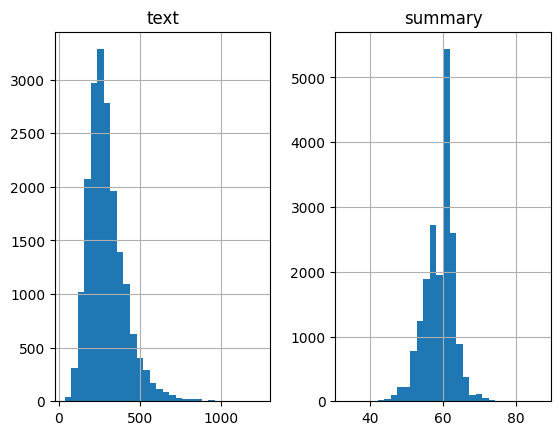

In [16]:
# %% Analyze length distribution of text and summary
text_word_count = [len(text.split()) for text in df['text']]
summary_word_count = [len(summary.split()) for summary in df['summary']]

# Plot histograms
length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [27]:
# Set maximum lengths based on histogram
max_text_len = 250
max_summary_len = 60

In [28]:
# Filter short texts and summaries based on maximum length
cleaned_text =np.array(df['text'])
cleaned_summary=np.array(df['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

In [29]:
df_short=pd.DataFrame({'text':short_text,'summary':short_summary})
df_short.head()

,text,summary
0,jakarta militer amerika serikat akan melakukan...,militer as dikabarkan akan melakukan uji coba ...
1,jakarta runner up motogp 2017 andrea dovizioso...,runner up motogp 2017 andrea dovizioso mengaku...
2,brimob polda metro jaya mendatangi kantor lkbn...,brimob polda metro jaya mendatangi kantor lkbn...
3,ribuan perempuan di washington cd amerika seri...,ribuan perempuan di washington cd amerika seri...
4,rimanews rumania akan dipimpin oleh seorang pe...,rumania akan dipimpin oleh seorang perdana men...


In [30]:
print(df_short['text'].str.split().str.len().max())
print(df_short['summary'].str.split().str.len().max())

250
60


In [33]:
# Add start and end tokens to summaries
df_filtered_full = pd.DataFrame({'text': df_short['text'], 'summary': df_short['summary']})
# df_filtered_full['summary'] = df_filtered_full['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

In [34]:
df_filtered_full.head()

,text,summary
0,jakarta militer amerika serikat akan melakukan...,militer as dikabarkan akan melakukan uji coba ...
1,jakarta runner up motogp 2017 andrea dovizioso...,runner up motogp 2017 andrea dovizioso mengaku...
2,brimob polda metro jaya mendatangi kantor lkbn...,brimob polda metro jaya mendatangi kantor lkbn...
3,ribuan perempuan di washington cd amerika seri...,ribuan perempuan di washington cd amerika seri...
4,rimanews rumania akan dipimpin oleh seorang pe...,rumania akan dipimpin oleh seorang perdana men...


In [35]:
df_filtered = df_filtered_full[:1000]


In [24]:
# %% Split dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

In [25]:
# %% Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'].tolist() + train_df['summary'].tolist())

# Convert text and summary into sequences
train_text_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=max_text_len, padding='post')
train_summary_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['summary']), maxlen=max_summary_len, padding='post')
val_text_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['text']), maxlen=max_text_len, padding='post')
val_summary_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['summary']), maxlen=max_summary_len, padding='post')
target_data = train_summary_seq

In [29]:
# %% Define the RNN-based Encoder-Decoder model
# Define model parameters
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 200  # Dimension of the embedding space
latent_dim = 256  # Latent dimensionality of the RNN

In [28]:
vocab_size

21018

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Define the model with max_summary_len
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_summary_len),
    SimpleRNN(units=latent_dim, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    lr_decay = 0.95
    return initial_lr * (lr_decay ** epoch)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
batch_size = 64
epochs = 10
history = model.fit(
    train_summary_seq,   # Use target length sequences as input
    target_data, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(val_summary_seq, val_summary_seq),  # Validation on summary length as well
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)


Epoch 1/10


c:\Users\ILHAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.1199 - loss: 9.6256 - val_accuracy: 0.2249 - val_loss: 7.7049 - learning_rate: 0.0010
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1642 - loss: 7.6122 - val_accuracy: 0.2242 - val_loss: 6.7710 - learning_rate: 9.5000e-04
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1624 - loss: 7.0756 - val_accuracy: 0.2243 - val_loss: 6.6267 - learning_rate: 9.0250e-04
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1599 - loss: 7.0011 - val_accuracy: 0.2243 - val_loss: 6.5601 - learning_rate: 8.5737e-04
Epoch 5/10
11/13 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1588 - loss: 6.9685

In [ ]:
# %% Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Training Result')
# plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Validation Result')
# plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
# %% Save the model
model.save(f'export/20-11_SEQ_simplernn_loss_{history.history['loss'][-1]}.h5')

In [36]:
# Take sample from new dataset to try summary for testing
df_predict = df_filtered_full[1000:1100]

In [37]:
df_predict

,text,summary
1000,algiers aljazair antara news pada rabu waktu s...,organisasi negara pengekspor minyak opec membu...
1001,jakarta kepala divisi humas polri inspektur je...,kepala divisi humas polri inspektur jenderal s...
1002,smartphone telah menyatu dengan kehidupan menu...,bagi pengguna smartphone berbasis android goog...
1003,jakarta chicco jerikho tidak merayakan lebaran...,chicco jerikho tidak merayakan lebaran meski b...
1004,jakarta presiden meksiko enrique pena nieto me...,presiden meksiko enrique pena nieto menunda re...
...,...,...
1095,jakarta manchester city menang telak atas leic...,manchester city menang telak atas leicester ci...
1096,jakarta kepolisian kota strasburg negara bagia...,mulai bulan ini kepolisian strasburg negara ba...
1097,tangerang polda metro jaya melalukan identifik...,polda metro jaya melalukan identifikasi korban...
1098,jakarta wakil gubernur dki jakarta sandiaga un...,wakil gubernur dki jakarta sandiaga uno memper...


In [43]:
df_predict.iloc[2]['text']

'smartphone telah menyatu dengan kehidupan menunjang berbagai aktivitas sehari hari membuat hidup lebih mudah efektif dan produktif kita pun menyimpan banyak data data penting ke dalamnya baik itu data pribadi ataupun data pekerjaan yang bersifat sensitif tidak heran jika kehilangan smartphone rasanya teramat menyakitkan saat itu terjadi jangan langsung pasrah begitu saja anda masih bisa mencoba untuk melacaknya mengunci dan menghapus data dari jarak jauh sehingga data data anda aman dan tidak disalahgunakan bagi pengguna smartphone berbasis android google telah memfasilitasi kebutuhan itu dengan fitur find my device make sure anda telah mengaktifkan hanya butuh 5 menit kok untuk mengaturnya agar melacak perangkat android yang hilang dengan find my phone harus memenuhi kriteria berikut find my device tak lain ialah versi terbaru dari android device manager dengan sejumlah peningkatan seperti ui baru dan kini dapat menampilkan informasi baterai dan wifi untuk memastikan find my device a

In [44]:
df_predict.iloc[2]['summary']

'bagi pengguna smartphone berbasis android google telah memfasilitasi kebutuhan itu dengan fitur find my device make sure anda telah mengaktifkan hanya butuh 5 menit kok untuk mengaturnya agar melacak perangkat android yang hilang dengan find my phone pastikan find my device dan fitur lokasi aktif jika anda menyembunyikan perangkat di google play pastikan visibilitas aktif'

In [26]:
df_predict.reset_index(inplace = True, drop = True)
df_predict.index = np.arange(len(df_predict))

In [ ]:
df_predict

In [ ]:
# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_text_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])


In [ ]:
# Try to summary from existing data
predicted_summaries = []
reference_summaries = []

for i in range(len(df_predict)):
    predicted_summary = generate_summary(df_predict['text'][i])
    
    
    predicted_summaries.append(predicted_summary)
    reference_summaries.append(df_predict['summary'][i])
    # print(predicted_summary)

In [ ]:
for i in range(len(predicted_summaries[:5])):
    print("Referenced: ", reference_summaries[i])
    print("Predicted: ", predicted_summaries[i])
    print("\n")

In [ ]:
from rouge_score import rouge_scorer
import numpy as np

# Function to evaluate using ROUGE and store precision, recall, and F-measure
def evaluate_rouge(predicted_summaries, reference_summaries):
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Initialize lists to accumulate precision, recall, and F-measure for each metric
    rouge1_precision, rouge1_recall, rouge1_fmeasure = [], [], []
    rouge2_precision, rouge2_recall, rouge2_fmeasure = [], [], []
    rougeL_precision, rougeL_recall, rougeL_fmeasure = [], [], []
    
    # Calculate ROUGE scores for each pair of reference and generated summaries
    for ref_summary, pred_summary in zip(reference_summaries, predicted_summaries):
        scores = scorer.score(ref_summary, pred_summary)
        
        # Store precision, recall, and F-measure for each ROUGE metric
        rouge1_precision.append(scores['rouge1'].precision)
        rouge1_recall.append(scores['rouge1'].recall)
        rouge1_fmeasure.append(scores['rouge1'].fmeasure)
        
        rouge2_precision.append(scores['rouge2'].precision)
        rouge2_recall.append(scores['rouge2'].recall)
        rouge2_fmeasure.append(scores['rouge2'].fmeasure)
        
        rougeL_precision.append(scores['rougeL'].precision)
        rougeL_recall.append(scores['rougeL'].recall)
        rougeL_fmeasure.append(scores['rougeL'].fmeasure)
    
    # Calculate the average precision, recall, and F-measure for each metric
    results = {
        "ROUGE-1": {
            "precision": np.mean(rouge1_precision),
            "recall": np.mean(rouge1_recall),
            "fmeasure": np.mean(rouge1_fmeasure)
        },
        "ROUGE-2": {
            "precision": np.mean(rouge2_precision),
            "recall": np.mean(rouge2_recall),
            "fmeasure": np.mean(rouge2_fmeasure)
        },
        "ROUGE-L": {
            "precision": np.mean(rougeL_precision),
            "recall": np.mean(rougeL_recall),
            "fmeasure": np.mean(rougeL_fmeasure)
        }
    }
    
    return results


In [ ]:
# Evaluate ROUGE scores
rouge_scores = evaluate_rouge(predicted_summaries, reference_summaries)
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value}")